# Analytic continuation with ana_cont

There is no general-purpose main program of ana_cont. Therefore the user has to write a script according to his needs. This is very simple and some examples are presented in this notebook.

First we have to import some libraries.

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

The ana_cont library can be imported directly, if it was installed properly. If not, or if there are multiple installations in your system, you should add the path to your favourite version:

In [4]:
sys.path.insert(0, os.environ['HOME']+'/Projects/ana_cont_github')
import ana_cont.continuation as cont

## Continuation of a fermionic Green's function

A fermionic Green's function $G(z)$ has complex values, and its values on the Matsubara frequencies are related to the spectral function $A(w)$ by
$$ G(i\omega_n) = \int_{-\infty}^\infty \frac{A(\omega)}{i\omega_n - \omega}.$$
The same relation holds for the self-energy as well, if the Hartree term is subtracted [J.M.Luttinger, Phys. Rev. 121, 942 (1961)].

Note that the spectral function is normalized to 1 only for diagonal elements of Green's functions. Diagonal elements of the self-energy are normalized to its first moment. Off-diagonal elements are normalized to 0. This simple example deals only with diagonal elements, off-diagonal elements are considered in a separate notebook. 

Here we consider the continuation from fermionic Matsubara frequencies to real frequencies. It is of course also possible to continue from imaginary time to real frequencies, but this has two disadvantages: First, if data are obtained from CT-QMC, they need to be collected in imaginary-time bins, which reduces accuracy in steep regions. (The binned value does not in general coincide with the actual value at the bin center.) Fourier-transformed data can be obtained directly by NFFT, without any binning error. Second, the Matsubara-representation is more compact, meaning that much fewer Matsubara frequencies than imaginary-time bins are needed. This makes the linear-algebra operations cheaper and thus the continuation faster. For the sake of completeness let it be mentioned that the package continues $G(-\tau)$ for positive values of $\tau$, i.e. positive values.

### Generate test data

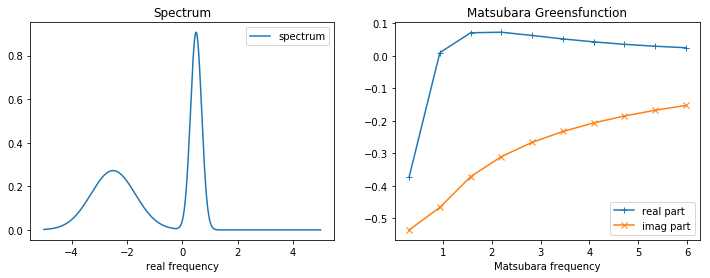

In [62]:
w_real = np.linspace(-5., 5., num=2001, endpoint=True)
spec_real = np.exp(-(w_real-0.5)**2 / (2.*0.2**2))
spec_real += 0.3 * np.exp(-(w_real+2.5)**2 / (2.*0.8**2))
spec_real /= np.trapz(spec_real, w_real) # normalization

beta = 10.
iw = np.pi/beta * (2.*np.arange(10) + 1.)

noise_amplitude = 1e-4 # create gaussian noise
noise_abs = np.random.normal(0., noise_amplitude, iw.shape[0])
noise_phase = np.random.uniform(0., 2.*np.pi, iw.shape[0])
noise = noise_abs * np.exp(1j * noise_phase)

kernel = 1./(1j*iw[:,None] - w_real[None,:])
gf_mats = np.trapz(kernel*spec_real[None,:], w_real, axis=1) + noise

fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
ax[0].plot(w_real, spec_real, label='spectrum')
ax[0].legend()
ax[0].set_xlabel('real frequency')
ax[0].set_title('Spectrum')
ax[1].plot(iw, gf_mats.real, label='real part', marker='+')
ax[1].plot(iw, gf_mats.imag, label='imag part', marker='x')
ax[1].legend()
ax[1].set_xlabel('Matsubara frequency')
ax[1].set_title('Matsubara Greensfunction')
plt.show()

### Create the continuation problem

The first important part of the analytic continuation script is the creation of an ```AnalyticContinuationProblem``` object. 
If the analytic continuation is done by the Maximum entropy method, we need the following input:
* Matsubara frequency grid (```im_axis```).
Only positive Matsubara frequencies should be used for the continuation. The number of frequencies to be used depends on temperature, but one should use only the region that contains physical information, i.e. the low-frequency region. The behaviour in the high-frequency region is trivial and encoded in the kernel. 
* Real frequency grid (```re_axis```).
The real frequency grid must cover the whole bandwidth of the spectrum (ideally a bit more). It does not need to be equispaced. On the contrary, it is often of advantage to make it denser in regions, where the spectral function is expected to have a complicated structure. 
* Imaginary axis data (```im_data```). 
The Green's function data belonging to the Matsubara frequencies given above. If you continue a self-energy, make sure that you subtracted the Hartree term. You might also like to normalize it by its first moment. 
* Kind of the Green's function (```kernel_mode```).
If you want to continue a fermionic Green's function or self energy from Matsubara frequencies, use ```kernel_mode='freq_fermionic'```

In [47]:
w = np.linspace(-5., 5., num=501, endpoint=True)
probl = cont.AnalyticContinuationProblem(im_axis=iw, re_axis=w, 
                                        im_data=gf_mats, kernel_mode='freq_fermionic')

### Solve the continuation problem

Now we can actually solve the problem. For this we use the maximum entropy method with singular value decomposition, ```method='maxent_svd'```.
This algorithm needs the following additional information:
* Alpha determination algorithm. It is recommended to use ```alpha_determination='classic'```, since the Bryan algorithm takes more time and does, in practice, rarely lead to better results. 
* Error estimate: passed to the solver through the keyword ```stdev```. It should have the same shape as ```im_axis```. For a first try in any continuation, it is recommended to set it to a largely exaggerated value, which leads to a fast, underfitted result. 
* Default model: passed to the solver through the keyword ```model```. For a first try, use a flat default model. However, you can use an arbitrarily creative model. By experience a function that strongly decays in the high-frequency region can be useful. It is also possible to re-use a spectrum that was obtained from continuation with strongly enlarged error estimate. 

In [48]:
err = np.ones_like(iw)*noise_amplitude
model = np.ones_like(w)
model /= np.trapz(model, w)
sol,_ = probl.solve(method='maxent_svd', alpha_determination='classic', stdev=err, model=model)

spectral points: 501
data points on imaginary axis: 20
significant singular values: 19
U (20, 19)
V (501, 19)
Xi (19,)
Precomputation of coefficient matrices
Solving...
log10(alpha)=6.0000	chi2=2.0824e+05	S=-5.1571e-01	tr=4.5268	conv=4.39e-06,	nfev=25,	norm=1.1275158646756167
log10(alpha)=5.0000	chi2=1.1021e+04	S=-7.3983e-01	tr=5.8073	conv=3.92e-05,	nfev=47,	norm=1.056532393554434
log10(alpha)=4.0000	chi2=1.0432e+03	S=-8.6741e-01	tr=7.0070	conv=0.000404,	nfev=184,	norm=1.0200654882199098
log10(alpha)=3.0000	chi2=4.0704e+01	S=-9.8178e-01	tr=8.0268	conv=0.00409,	nfev=560,	norm=1.0055315327990506
log10(alpha)=2.0000	chi2=7.7232e+00	S=-1.0151e+00	tr=8.9467	conv=0.0441,	nfev=2217,	norm=1.0019141037805404
log10(alpha)=1.0000	chi2=6.3189e+00	S=-1.0348e+00	tr=9.5609	conv=0.462,	nfev=10106,	norm=1.00093611311726
log10(alpha)=0.0000	chi2=5.9459e+00	S=-1.0990e+00	tr=10.0990	conv=4.59,	nfev=69816,	norm=1.0006715489708005
prediction for optimal alpha: 4.611283424345136 log10(alphaOpt)= 0.6638218161

### Plot the result
Now we can plot the result of the continuation. It is highly recommended to look at two kinds of plots. First, one should look at the backtransform and compare it to the original data. (Plotting one over another, or the difference.) The backtransform should be a good fit, but of course you should not try to fit noise. 
Second, one should check, if the result looks reasonably. In the case of noise-fitting, peaks become sharp and hight, and even additional peaks can appear. Another typical symptom is that spectral weight is shifted to the borders of the real-frequency interval. 

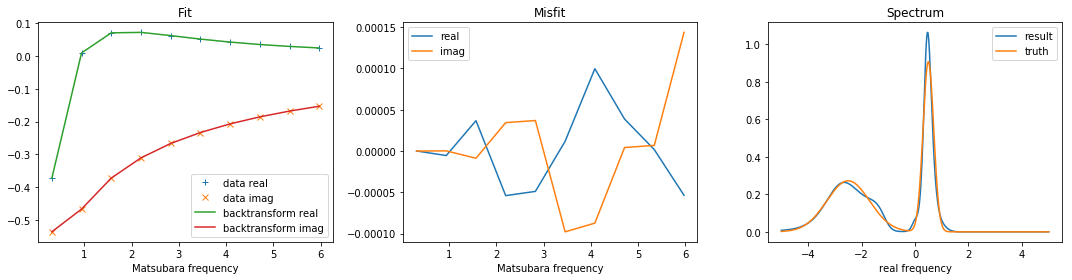

In [60]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,4))
ax[0].plot(iw, gf_mats.real, linestyle='None', marker='+', label='data real')
ax[0].plot(iw, gf_mats.imag, linestyle='None', marker='x', label='data imag')
ax[0].plot(iw, sol.backtransform.real, label='backtransform real')
ax[0].plot(iw, sol.backtransform.imag, label='backtransform imag')
ax[0].legend()
ax[0].set_xlabel('Matsubara frequency')
ax[0].set_title('Fit')
ax[1].plot(iw, gf_mats.real-sol.backtransform.real, label='real')
ax[1].plot(iw, gf_mats.imag-sol.backtransform.imag, label='imag')
ax[1].legend()
ax[1].set_xlabel('Matsubara frequency')
ax[1].set_title('Misfit')
ax[2].plot(w, sol.A_opt, label='result')
ax[2].plot(w_real, spec_real, label='truth')
ax[2].legend()
ax[2].set_xlabel('real frequency')
ax[2].set_title('Spectrum')
plt.tight_layout()
plt.show()

## Constructing a full complex-valued Green's function from a spectrum

Especially when one continues a self-energy, one usually wants not only its spectrum, but rather the full Green's function. The spectrum is related to the *imaginary* part of the retarded Green's function:
$$
A(\omega) = -\frac{1}{\pi} \mathrm{Im} G(\omega)
$$
The Kramers-Kronig relations provide a way to get the real part from the imaginary part:
$$
\mathrm{Re} G(\omega) = \frac{1}{\pi} \mathcal{P} \int_{-\infty}^\infty d\omega 
    \frac{\mathrm{Im} G(\omega')}{\omega'-\omega}.
$$
This functionality is implemented in the class ```GreensFunction```, which has a method ```kkt()```. The following line of code produces a warning, which can be safely ignored. (In the integration kernel, a division $0/0$ occurs. The respective value is set by hand, however.)

In [63]:
gf_full = cont.GreensFunction(spectrum=sol.A_opt, wgrid=w, kind='fermionic').kkt()

/home/josef/Projects/ana_cont_github/ana_cont/continuation.py:350: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


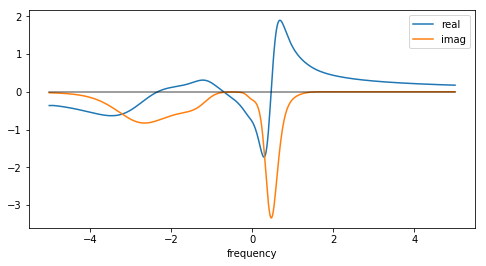

In [64]:
fig = plt.figure(figsize=(8,4))
plt.plot(w, gf_full.real, label='real')
plt.plot(w, gf_full.imag, label='imag')
plt.plot(w, np.zeros_like(w), color='black', alpha=0.5)
plt.xlabel('frequency')
plt.legend()
plt.show()

## Continuation of a bosonic Green's function

The continuation of a bosonic Green's function (response function) works very similar to the fermionic case. 
It is arguably even simpler. There are howvever a few points to consider:
* Trivial but a common source of mistakes: you have to use bosonic Matsubara frequencies. 
* The implemented kernel assumes that bosonic Green's functions are purely real on the imaginary axis. 
* Only positive real frequencies must be used, as the symmetry of bosonic spectra is encoded in the kernel.
* At $\omega = i\omega_0 = 0$, the kernel diverges. 

The problem of the last point is mitigated by defining the spectrum as $A(\omega) = G(\omega)/\omega$, where $G$ is the actual response function. This leads to the relation
$$
G(i\omega_n) = \int_0^\infty d\omega \frac{\omega^2}{\omega^2+\omega_n^2} A(\omega)
$$

Apart from the differences just mentioned, the continuation workflow is the same as in the fermionic case. Therefore, it is recommended to read the above section about fermionic continuation first. In the following only the comments only address differences in the bosonic case. 

### Generate test data

/home/josef/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/josef/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


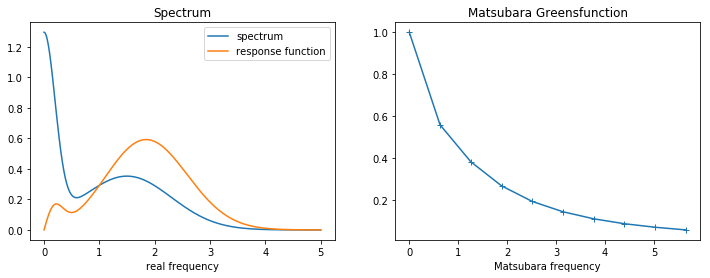

In [96]:
w_real = np.linspace(0., 5., num=2001, endpoint=True)
spec_real = np.exp(-(w_real)**2 / (2.*0.2**2))
spec_real += 0.3 * np.exp(-(w_real-1.5)**2 / (2.*0.8**2))
spec_real += 0.3 * np.exp(-(w_real+1.5)**2 / (2.*0.8**2))# must be symmetric around 0!
spec_real /= np.trapz(spec_real, w_real) # normalization

beta = 10.
iw = 2. * np.pi/beta * np.arange(10)

noise_amplitude = 1e-4 # create gaussian noise
noise = np.random.normal(0., noise_amplitude, iw.shape[0])

kernel = (w_real**2)[None,:]/((iw**2)[:,None] + (w_real**2)[None,:])
kernel[0,0] = 1.
gf_bos = np.trapz(kernel*spec_real[None,:], w_real, axis=1) + noise
norm = gf_bos[0]
gf_bos /= norm
fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
ax[0].plot(w_real, spec_real, label='spectrum')
ax[0].plot(w_real, w_real*spec_real, label='response function')
ax[0].legend()
ax[0].set_xlabel('real frequency')
ax[0].set_title('Spectrum')
ax[1].plot(iw, gf_bos.real, marker='+')
ax[1].set_xlabel('Matsubara frequency')
ax[1].set_title('Matsubara Greensfunction')
plt.show()

### Set the problem

* Use only positive frequencies
* Use bosonic Matsubara frequencies
* Use ```kernel_mode='freq_bosonic'```

In [97]:
w = np.linspace(0., 5., num=501, endpoint=True)
probl = cont.AnalyticContinuationProblem(im_axis=iw, re_axis=w, 
                                        im_data=gf_bos, kernel_mode='freq_bosonic')

### Solve the problem

In [98]:
err = np.ones_like(iw) * noise_amplitude / norm
model = np.ones_like(w)
model /= np.trapz(model, w)
sol,_ = probl.solve(method='maxent_svd', alpha_determination='classic', stdev=err, model=model)

/home/josef/Projects/ana_cont_github/ana_cont/solvers.py:79: RuntimeWarning: invalid value encountered in true_divide
  + (self.im_axis ** 2)[:, None])


spectral points: 501
data points on imaginary axis: 10
significant singular values: 9
U (10, 9)
V (501, 9)
Xi (9,)
Precomputation of coefficient matrices
Solving...
log10(alpha)=6.0000	chi2=7.5631e+04	S=-4.2856e-01	tr=2.8348	conv=3.31e-06,	nfev=9,	norm=0.9870925272964193
log10(alpha)=5.0000	chi2=8.3796e+03	S=-5.1808e-01	tr=3.5560	conv=3.43e-05,	nfev=10,	norm=0.9984127384925389
log10(alpha)=4.0000	chi2=2.5853e+02	S=-6.1105e-01	tr=4.1283	conv=0.000338,	nfev=90,	norm=0.9998197909357585
log10(alpha)=3.0000	chi2=7.2973e+00	S=-6.3495e-01	tr=4.7667	conv=0.00375,	nfev=279,	norm=0.9999813864653236
log10(alpha)=2.0000	chi2=3.2389e+00	S=-6.3982e-01	tr=5.2523	conv=0.041,	nfev=1871,	norm=0.9999980937532813
log10(alpha)=1.0000	chi2=2.4482e+00	S=-6.5146e-01	tr=5.7249	conv=0.439,	nfev=11448,	norm=0.9999998030118783
log10(alpha)=0.0000	chi2=2.3483e+00	S=-6.6520e-01	tr=6.0342	conv=4.54,	nfev=56292,	norm=0.9999999806171267
prediction for optimal alpha: 4.443358854528208 log10(alphaOpt)= 0.647711389146321

### Plot the results
Remember that the code calculates the *spectrum*. To get the response function on the real axis, multiply the spectrum by $\omega$!

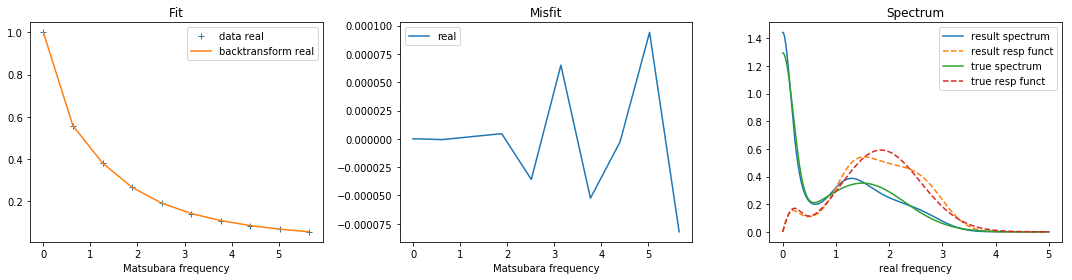

In [99]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,4))
ax[0].plot(iw, gf_bos.real, linestyle='None', marker='+', label='data real')
ax[0].plot(iw, sol.backtransform.real, label='backtransform real')
ax[0].legend()
ax[0].set_xlabel('Matsubara frequency')
ax[0].set_title('Fit')
ax[1].plot(iw, gf_bos.real-sol.backtransform.real, label='real')
ax[1].legend()
ax[1].set_xlabel('Matsubara frequency')
ax[1].set_title('Misfit')
ax[2].plot(w, sol.A_opt, label='result spectrum')
ax[2].plot(w, w*sol.A_opt, label='result resp funct', linestyle='--')
ax[2].plot(w_real, spec_real, label='true spectrum')
ax[2].plot(w_real, w_real*spec_real, label='true resp funct', linestyle='--')
ax[2].legend()
ax[2].set_xlabel('real frequency')
ax[2].set_title('Spectrum')
plt.tight_layout()
plt.show()